# Chuẩn bị


1. Tải Stockfish từ trang chính thức: https://stockfishchess.org/download/

2. Sau khi tải về, đổi tên file `.exe` thành `stockfish`

3. Di chuyển file này vào thư mục: `chess-bot/.venv/bin/`

4. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

5. Di chuyển file này vào thư mục chess-bot

6. Vào evaluation vô hiệu 2 dòng hàm load_from_json() trong hàm __init__().

## Import thư viện cần thiết

In [1]:
from stockfish import Stockfish
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.svg
from typing import List
import pandas as pd
from IPython.display import display, SVG, HTML
import math
from evaluation.evaluation import Evaluation
from evaluation.piece_square_table import PieceSquareTable


[8, 9, 16, 17]


## Config đường dẫn

In [2]:
stockfish_path = ".venv/bin/stockfish"
# stockfish_path = ".venv/Scripts/stockfish.exe"

## Stockfish Engine

In [3]:
stockfish = Stockfish(stockfish_path)
stockfish.set_skill_level(10)
stockfish.set_depth(5)

In [4]:
def get_stockfish_score(fen: str) -> float:
    stockfish.set_fen_position(fen)
    score = stockfish.get_evaluation()
    return score["value"]

## Lấy tập dữ liệu

In [5]:
df = pd.read_csv('chessData.csv')
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [6]:
sampled_df = df.sample(n=8000, random_state=10)
test_fens = sampled_df['FEN'].to_list()
"""stockfish_scores = (
    sampled_df['Evaluation']
    .astype(str)
    .str.replace("+", "", regex=False)
    .str.extract(r'([-]?\d+)')[0]
    .astype(float)
    .fillna(0)
    .astype(int)
    .tolist()
)"""
stockfish_scores = [get_stockfish_score(fen) for fen in test_fens]


print(stockfish_scores)
print(sum(stockfish_scores))

[-257, -83, 22, 196, 135, 10, -166, -507, -72, -84, -77, -365, 27, 66, 33, 174, 243, 96, 216, -136, 46, 75, 7, 22, -114, 429, 80, -6, -187, 214, 28, -20, 58, 109, -474, -43, 44, -240, 233, -6, -127, 367, 99, -18, 46, 24, 246, 128, 12, 3, 121, 49, -69, -48, 66, -252, 284, -2, -163, 109, -2, -334, -30, -214, 0, -67, 354, -72, 52, -37, 170, -110, 34, 70, 208, -44, -557, -405, 132, -377, 30, 27, 244, -287, 50, -325, 5, 374, -57, 187, -425, -3, 40, -3, 131, -104, -24, -10, 15, -89, 52, 110, 119, 66, -234, -421, 74, -686, -35, 126, 193, 376, 0, 57, 417, -5, 4, 244, 386, 459, 755, 343, -103, -673, 42, 176, -2, 52, 15, 400, 105, 40, 59, -3, -437, -7, 103, -161, 61, 16, -210, 91, -41, 25, -44, -48, -8, 146, -59, -319, 545, 445, 101, 21, 17, 215, -199, 146, 165, -119, -387, 95, -172, 449, 182, 521, 10, 14, 432, 116, 22, 79, 188, 95, 174, 383, -30, 88, -20, 144, 638, 117, 98, -36, 437, 159, 579, -6, -14, -499, 45, 122, -358, 460, 327, -122, 244, -429, 209, 67, 395, 102, 29, 159, 377, -23, -12, -1

In [7]:
sampled_df['Evaluation'] = stockfish_scores
sampled_df.to_csv("sample.csv")

## Visualization

In [8]:
def showBoard(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)
    
    for row in range(rows):
        boards_in_row = []
        for col in range(boards_per_row):
            idx = row * boards_per_row + col
            if idx < total_boards:
                board = chess.Board(fens[idx])
                svg = chess.svg.board(board, size=200)  # Giảm size nếu cần
                boards_in_row.append(SVG(svg)._repr_svg_())  # Lấy chuỗi SVG
        
        # Tạo HTML với flexbox để xếp hàng ngang
        html = f"""
        <div style="display: flex; flex-wrap: nowrap; gap: 10px; margin: 10px 0;">
            {''.join(boards_in_row)}
        </div>
        """
        display(HTML(html))

In [9]:
#showBoard(df.sample(n=50, random_state=42)['FEN'].to_list())

# 1. Initialization

In [10]:
evaluation_length = len(Evaluation.to_array())
def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.
    
    - The first 5 parameters (evaluation weights) are floating-point numbers.
    - The remaining parameters (piece values, penalties, multipliers) are integers.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """
    origin_array = Evaluation.to_array()  
    # Define bounds for each gene type
    bounds = []
    for value in origin_array:

        lower_bound = min(int(value * 0.8),int(value * 1.2)) 
        upper_bound = max(int(value * 0.8),int(value * 1.2))
        bounds.append([lower_bound, upper_bound])


    num_params = len(bounds)

    # Generate population matrix
    population = np.zeros((size, num_params))

    for i in range(num_params):
        low, high = bounds[i]
        population[:, i] = np.random.randint(low, high + 1, size=size)
    return population



# Fitness function

In [11]:
from bisect import bisect_left
from typing import List

class FenwickTree:
    def __init__(self, size):
        self.n = size + 2
        self.tree = [0] * self.n

    def update(self, index, value):
        index += 1
        while index < self.n:
            self.tree[index] += value
            index += index & -index

    def query(self, index):
        index += 1
        result = 0
        while index:
            result += self.tree[index]
            index -= index & -index
        return result

def compute_inversion_cost(A: List[int], B: List[int]) -> int:
    n = len(A)
    zipped = list(zip(A, B))
    zipped.sort()  # Sort A tăng

    # Nén giá trị B lại cho nhỏ để dùng Fenwick Tree
    sorted_B = sorted(set(B))
    B_to_idx = {b: i for i, b in enumerate(sorted_B)}

    bit = FenwickTree(len(sorted_B))
    cost = 0

    for _, b in zipped:
        idx = B_to_idx[b]
        # Tổng số B đã xét - số lượng B <= b
        cost += bit.query(len(sorted_B) - 1) - bit.query(idx)
        bit.update(idx, 1)

    return cost

In [12]:
temp = 0
def fitness_function(weights: List[float]) -> float:
    Evaluation.update(weights)
    evaluator = Evaluation()
    
    evals = []
    for fen in test_fens:
        eval_score = evaluator.evaluate(chess.Board(fen))
        evals.append(eval_score)

    global temp
    if(temp == 0):
        print(evals)
        print("/n")
        print(stockfish_scores)
        temp = 2
        
    inversion_cost = compute_inversion_cost(evals, stockfish_scores)
    
    return -inversion_cost  # Càng ít nghịch đảo, fitness càng cao


# Selection

In [13]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [14]:
def crossover_mixed(parent1, parent2, alpha=0.4, crossover_rate=0.5):
    """
    Perform crossover with an adaptive probability.

    Args:
        parent1 (np.array): First parent.
        parent2 (np.array): Second parent.
        alpha (float): Alpha parameter for BLX-α crossover (for floats).
        crossover_rate (float): Probability of crossover.

    Returns:
        np.array: Child with mixed-type values.
    """
    p1, p2 = np.array(parent1), np.array(parent2)
    child = np.zeros_like(p1)

    for i in range(len(p1)):
        if np.random.rand() < crossover_rate:  # Perform crossover with given probability
            min_val, max_val = min(p1[i], p2[i]), max(p1[i], p2[i])
            range_val = max_val - min_val
            child[i] = int(min_val - alpha * range_val + np.random.rand() * (1 + 2 * alpha) * range_val)
            #remove int if wanna it is float number
        else:
            child[i] = np.random.choice([p1[i], p2[i]])  # Inherit directly from a parent

    return child


# Mutation

In [15]:
def mutate_propotion(individual, strength = 0.3):
    mutated = np.copy(individual)
    rate1=np.random.uniform(0.7, 1.3)
    for i in range (piece_square_table_length):
        mutated[i] *= rate1

    rate2=np.random.uniform(0.7, 1.3)
    for i in range (piece_square_table_length,piece_square_table_length+evaluation_length):
        mutated[i] *= rate2
    
    return mutated



In [16]:
def mutate_mixed(individual, mutation_rate=0.3,strength = 0.3):
    """
    Apply adaptive mutation to floating-point and integer genes.

    Args:
        individual (np.array): Individual's genes.
        mutation_rate (float): Probability of mutation.

    Returns:
        np.array: Mutated individual.
    """
    mutated = np.copy(individual)
    #maybe use can strength instead of 1,0,-1 
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Mutation occurs with probability
            mutate_range = math.ceil(abs(mutated[i])) * strength
            step = np.random.normal(loc=0.0, scale=mutate_range) #hàm theo phân phối gauss            
            mutated[i] += step
            mutated[i] = int(mutated[i])

    return mutated


In [17]:
def adaptive_mutation_rate(generation, max_generations, min_rate=0.05, max_rate=0.25, decay_factor=1.2):
    """
    Adaptive mutation rate: Decreases as generations progress.
    """
    return max_rate * (1 - (generation / max_generations))**decay_factor + min_rate

In [18]:

def adaptive_crossover_rate(generation, max_generations, min_rate=0.4, max_rate=0.7):
    """
    Adaptive crossover rate: Increases as generations progress.
    """
    return min_rate + (max_rate - min_rate) * (generation / max_generations)


# GA

In [ ]:
"""[ 95. 225. 205. 372. 902.   0.   0.   0.   0.   2.   0.   0.  98.  80.
  31.  43.  10.  18.]"""

In [19]:
def genetic_algorithm(
    fitness_function,
    population_size=200,
    property_generations = 0,
    generations=100,
    elite_size=7,
    tournament_size=4,
    convergence_threshold=10,
    epxilon = 0.005
):
    """
    Runs an optimized Genetic Algorithm with adaptive mutation and crossover rates.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals retained.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if no improvement.
        epxilon (double): count no improvement if can better epxilon time

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf
    no_improvement_count = 0
    step = 1 if property_generations != 0 else 2

    for generation in range(generations):
        # Adaptive rates
        mutation_rate = adaptive_mutation_rate(generation, generations)
        crossover_rate = adaptive_crossover_rate(generation, generations)

        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])

        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)

        # Check if fitness improved
        #fitness is negative so -epxilon
        if current_best_fitness > best_fitness * (1 - epxilon):
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if (generation == property_generations) or (no_improvement_count >= convergence_threshold and step == 1):
            no_improvement_count = 0
            step = 2
            if property_generations != 0:
                print(f"✅ stop change properties after {generation} generations! Start normal GA.")

        # Stop early if fitness has not improved
        if no_improvement_count >= convergence_threshold and step == 2:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        if step == 2:
            for _ in range(population_size - elite_size):
                p1 = tournament_selection(population, fitness_scores, tournament_size)
                p2 = tournament_selection(population, fitness_scores, tournament_size)
                child = crossover_mixed(p1, p2, crossover_rate=crossover_rate)
                child = mutate_mixed(child, mutation_rate, 0.1)
                new_population.append(child)
        elif step == 1:
            for _ in range(population_size - elite_size):
                #chi can 1 ca the vi dang nao cung la tim ti le 2
                p = tournament_selection(population, fitness_scores, tournament_size)
                child = mutate_propotion(p)
                new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}, Mutation Rate = {mutation_rate:.3f}, Crossover Rate = {crossover_rate:.3f}")

    return population[0], best_fitness_history


# Tuning

[np.float64(284.0), np.float64(-391.0), np.float64(-25.0), np.float64(-478.0), np.float64(148.0), np.float64(91.0), np.float64(102.0), np.float64(-504.0), np.float64(-75.0), np.float64(-392.0), np.float64(-147.0), np.float64(51.0), np.float64(22.0), np.float64(-276.0), np.float64(26.0), np.float64(-286.0), np.float64(209.0), np.float64(65.0), np.float64(-89.0), np.float64(-353.0), np.float64(55.0), np.float64(139.0), np.float64(-109.0), np.float64(84.0), np.float64(-183.0), np.float64(-28.0), np.float64(-140.0), np.float64(14.0), np.float64(790.0), np.float64(-308.0), np.float64(364.0), np.float64(-45.0), np.float64(69.0), np.float64(-189.0), np.float64(73.0), np.float64(-15.0), np.float64(-147.0), np.float64(130.0), np.float64(189.0), np.float64(-220.0), np.float64(-5.0), np.float64(189.0), np.float64(-203.0), np.float64(-78.0), np.float64(-276.0), np.float64(83.0), np.float64(66.0), np.float64(-20.0), np.float64(-9.0), np.float64(9.0), np.float64(-296.0), np.float64(-72.0), np.float6

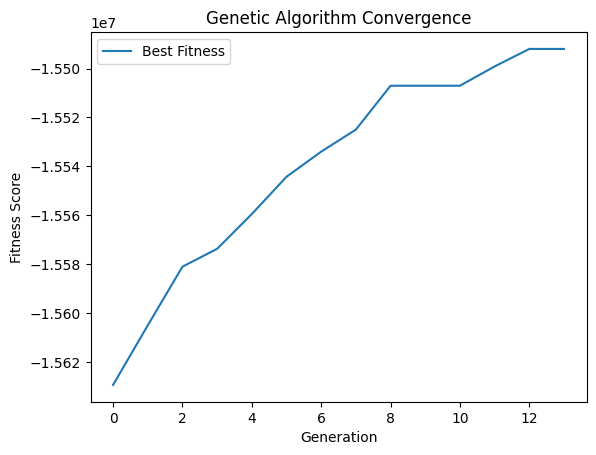

Optimized Weights: [ 95. 225. 205. 372. 902.   0.   0.   0.   0.   2.   0.   0.  98.  80.
  31.  43.  10.  18.]


In [ ]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=150, generations=80, elite_size=7, convergence_threshold=5, epxilon = 0.00)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:",best_weights)
temp = 0
Evaluation.update(best_weights)
Evaluation.save_to_json(Evaluation.path)